In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from statsmodels.tsa.arima.model import ARIMAResults, ARIMA
from scipy.stats import burr, burr12, fisk
from pykalman import KalmanFilter

from utils import *
from tqdm import tqdm

In [ ]:
cwd = os.getcwd()

full_data = pd.read_csv(os.path.join(cwd, 'data\\full_v3.csv'))
full_data['Price'] = full_data['Price'].apply(np.log)

In [ ]:
data = full_data

In [ ]:
data = full_data.drop(columns=['YoY','MoM-1','MoM-2','MoM-3','MoM-4','MoM-5','MoM-6'])

In [ ]:
data_2013_1 = data[(data['Year']==2013.0) & (data['Month']==1.0)]

In [ ]:
c, d, loc, scale = burr.fit(data_2013_1['Price'])

In [ ]:
pct = burr.cdf(data_2013_1['Price'],c,d,loc,scale)
price = burr.ppf(pct,c,d,loc,scale)

In [ ]:
pd.options.mode.chained_assignment = None
data_pct = data_2013_1.drop(columns=['Price','Year','Month']).iloc[:0]
test_data = data_pct.copy()
test_data

,PropID,Suburb,Bedrms,Bathrms,Cars,LandSize,BuildingArea,YearBuilt,ICSEA_Primary,ICSEA_Year7,IRSD,IRSAD,IER,IEO,Population


In [ ]:
for year in np.linspace(2013.0,2016.0,4):
    for month in np.linspace(1.0,12.0,12):
        temp_data = data[(data['Year']==year) & (data['Month']==month)]
        c, d, loc, scale = burr.fit(temp_data['Price'])
        pct = burr.cdf(temp_data['Price'],c,d,loc,scale)
        temp_data = temp_data.drop(columns=['Price','Year','Month'])
        temp_data['pct'] = pct
        data_pct = pd.concat([data_pct,temp_data],ignore_index=True)

In [ ]:
for month in np.linspace(1.0,12.0,12):
    temp_data = data[(data['Year']==2017.0) & (data['Month']==month)]
    c, d, loc, scale = burr.fit(temp_data['Price'])
    pct = burr.cdf(temp_data['Price'],c,d,loc,scale)
    temp_data = temp_data.drop(columns=['Price','Year','Month'])
    temp_data['pct'] = pct
    test_data = pd.concat([test_data,temp_data],ignore_index=True)

In [ ]:
p = []
for i in tqdm(range(test_data.shape[0])):
    t = test_data.iloc[i,]
    p.append([t['pct']]+list(data_pct[(data_pct['PropID']==t['PropID'])]['pct']))

100%|██████████| 29200/29200 [09:37<00:00, 50.54it/s]


In [ ]:
p

[[0.9438826790039467],
 [0.9871145307901423],
 [0.2307797070275812],
 [0.6356560949567803, 0.35535353578438655],
 [0.2724958862011862],
 [0.4722217211473515],
 [0.5711606903823314],
 [0.652789083581764],
 [0.599960796162872],
 [0.9121039169043544],
 [0.7939328811113046],
 [0.8869334114641946],
 [0.9355443403218185],
 [0.9389363008697793],
 [0.9837892829003417],
 [0.9837892829003417],
 [0.9837892829003417],
 [0.9382773897663009],
 [0.9408572994875533, 0.8308462841779176],
 [0.8094732007120308],
 [0.8403659299484104, 0.5783212269617953],
 [0.6241534864286503],
 [0.23906252225394561, 0.13174911568347308],
 [0.3579646830380025, 0.14734701636244085],
 [0.7108478473412412],
 [0.6485910239035159],
 [0.7108478473412412],
 [0.9837892829003417],
 [0.9793156379196908],
 [0.6746194428260895, 0.40789136751323246],
 [0.6746194428260895, 0.40789136751323246],
 [0.8203728493208948],
 [0.6746194428260895, 0.40789136751323246],
 [0.6746194428260895, 0.40789136751323246],
 [0.5559831321974239],
 [0.61359

In [ ]:
r1 = []
r2 = []
for i in p:
    if len(i) > 1:
        

In [ ]:
X_train = data_pct.drop(columns='pct')
y_train = data_pct['pct']
temp = test_data.drop(columns='pct')
y_temp = test_data['pct']
X_dev, X_test, y_dev, y_test = train_test_split(temp, y_temp, test_size=0.5, random_state=31)
X_train.shape, X_dev.shape, X_test.shape

((131069, 13), (14600, 13), (14600, 13))

In [ ]:
m = xgb.sklearn.XGBRegressor(n_estimators=150, verbosity=0,
    objective='reg:squarederror', early_stopping_rounds=5, subsample = 0.8, reg_lambda = 2, reg_alpha = 4, max_leaves = 200, max_depth = 10, learning_rate = 0.1)
m.fit(X_train, y_train, eval_set=[(X_dev, y_dev)])

[0]	validation_0-rmse:0.27138
[1]	validation_0-rmse:0.24990
[2]	validation_0-rmse:0.23078
[3]	validation_0-rmse:0.21389
[4]	validation_0-rmse:0.19899
[5]	validation_0-rmse:0.18603
[6]	validation_0-rmse:0.17444
[7]	validation_0-rmse:0.16460
[8]	validation_0-rmse:0.15594
[9]	validation_0-rmse:0.14838
[10]	validation_0-rmse:0.14208
[11]	validation_0-rmse:0.13676
[12]	validation_0-rmse:0.13218
[13]	validation_0-rmse:0.12823
[14]	validation_0-rmse:0.12461
[15]	validation_0-rmse:0.12171
[16]	validation_0-rmse:0.11925
[17]	validation_0-rmse:0.11703
[18]	validation_0-rmse:0.11533
[19]	validation_0-rmse:0.11385
[20]	validation_0-rmse:0.11268
[21]	validation_0-rmse:0.11165
[22]	validation_0-rmse:0.11060
[23]	validation_0-rmse:0.10980
[24]	validation_0-rmse:0.10927
[25]	validation_0-rmse:0.10875
[26]	validation_0-rmse:0.10826
[27]	validation_0-rmse:0.10799
[28]	validation_0-rmse:0.10757
[29]	validation_0-rmse:0.10720
[30]	validation_0-rmse:0.10688
[31]	validation_0-rmse:0.10658
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=200, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=4,
             reg_lambda=2, ...)

In [ ]:
temp_test = data[(data['Year']==2017.0) & (data['Month']==1.0)].drop(columns=['Price','Year','Month'])
y = data[(data['Year']==2017.0) & (data['Month']==1.0)]['Price']
y

314       14.115615
542       14.639686
1006      12.994530
1027      13.410545
1077      13.038982
            ...    
160203    13.249877
160223    12.700769
160234    13.017003
160259    13.321214
160265    13.321214
Name: Price, Length: 1344, dtype: float64

In [ ]:
pred = m.predict(temp_test)
pred

array([0.7877179 , 0.9304172 , 0.11067282, ..., 0.2349762 , 0.47425205,
       0.46808845], dtype=float32)

In [ ]:
temp_data = data[(data['Year']==2016.0) & (data['Month']==12.0)]
c, d, loc, scale = burr.fit(temp_data['Price'])
y_pred = burr.ppf(pred,c,d,loc,scale)
pct_error(y, y_pred, log=True).abs().mean()

0.846427180682846

In [ ]:
result_burr = []
for month in np.linspace(2.0,12.0,11):
    temp_test = data[(data['Year']==2017.0) & (data['Month']==month)].drop(columns=['Price','Year','Month'])
    y = data[(data['Year']==2017.0) & (data['Month']==month)]['Price']
    pred = m.predict(temp_test)
    temp_data = data[(data['Year']==2017.0) & (data['Month']==month-1)]
    c, d, loc, scale = burr.fit(temp_data['Price'])
    print(y.shape,c,d,loc,scale)
    y_pred = burr.ppf(pred,c,d,loc,scale)
    result_burr.append(pct_error(y, y_pred, log=True).abs().mean())

(2721,) 41.612887368441925 4.383120774044977 -0.17507374322671307 12.880678451199248
(3648,) 31.992667792358496 8.73758132805405 -0.17259713724695253 12.591651945910584
(2908,) 30.328672079264663 277.08622064465993 -0.9504625771605812 11.865324085553915
(3270,) 33.24637885253977 6.22579202528503 -0.18866845145629482 12.820620637713183
(2731,) 29.800613642896103 22.09626566750938 -0.2335777261189363 12.249879187755237
(2839,) 32.262423512707585 322.81835474508705 -1.166028000044192 12.129879475548066
(2862,) 36.81844317825624 28.843555226820023 -0.26341912040034465 12.372125275121398
(2731,) 36.63726700910189 363.23598568412444 -1.3753237407590606 12.524434430289498
(2711,) 36.784382058607676 5.275558642409732 -0.19984588877375642 13.03329558765886
(992,) 35.499604305559544 9.83829723743817 -0.20370528786375974 12.781000223186586
(443,) 37.477577791377634 6.950401613667808 -0.22873756124852526 12.933265549502234


In [ ]:
result_burr

[2.0749066833971224,
 1.092131216778603,
 0.8959992059525751,
 1.077134946075003,
 0.9501537802203981,
 0.879107936791764,
 1.406008102521214,
 1.1785530038977312,
 1.0571690307922423,
 0.9941629745447543,
 1.0643229777212047]

In [ ]:
result_fisk = []
for month in np.linspace(2.0,12.0,11):
    temp_test = data[(data['Year']==2017.0) & (data['Month']==month)].drop(columns=['Price','Year','Month'])
    y = data[(data['Year']==2017.0) & (data['Month']==month)]['Price']
    pred = m.predict(temp_test)
    temp_data = data[(data['Year']==2017.0) & (data['Month']==month-1)]
    c, loc, scale = fisk.fit(temp_data['Price'])
    print(y.shape,c,loc,scale)
    y_pred = fisk.ppf(pred,c,loc,scale)
    result_fisk.append(pct_error(y, y_pred, log=False).abs().mean())

(2721,) 6.204911881746805 11.771233243091068 1.4850151510393976
(3648,) 43.72998605589564 -0.28174610703148995 13.76143690366326
(2908,) 4.152755439478833 12.148738222533328 1.355065345410136
(3270,) 5.855847637293786 11.725388225208636 1.7634239872397766
(2731,) 5.0181835951397735 11.90570168056517 1.6183669569706074
(2839,) 4.225471501441621 12.195203942706165 1.3143561452695467
(2862,) 4.414531478489268 12.290828750230546 1.1253259707374361
(2731,) 3.937305782938727 12.372920185732742 1.0983386986669053
(2711,) 6.9519518032275105 11.624573125026732 1.929112066923354
(992,) 4.888576207750144 12.20414537187455 1.3482831474802026
(443,) 5.390703553496936 12.075633902049058 1.4253214139214898


In [ ]:
result_fisk

[24.148511419346516,
 15.485921221509686,
 12.16800056732464,
 13.743697868268082,
 12.591053227142424,
 11.383077497385981,
 17.011665915322713,
 15.24064074398549,
 13.547902404189703,
 15.240271672337412,
 13.578062216454628]

In [ ]:
np.array(result_burr)-np.array(result_fisk)

array([-0.06028122, -0.1771763 , -0.01331412, -0.0079249 , -0.01136251,
        0.00539215, -0.01252107, -0.02032415, -0.02503433, -0.00476708,
       -0.03738593])

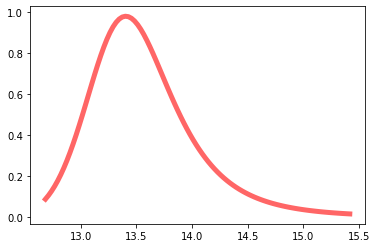

In [ ]:
x = np.linspace(fisk.ppf(0.01, c, loc, scale),
                fisk.ppf(0.99, c, loc, scale), 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, fisk.pdf(x, c, loc, scale),
       'r-', lw=5, alpha=0.6, label='burr pdf')

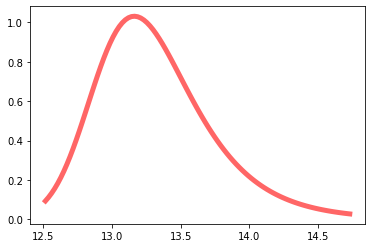

In [ ]:
c, d, loc, scale = (41.612887368441925, 4.383120774044977, -0.17507374322671307, 12.880678451199248)
x = np.linspace(burr.ppf(0.01, c, d, loc, scale),
                burr.ppf(0.99, c, d, loc, scale), 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6, label='burr pdf')